# Exploratory Geovisualization with PySAL

## Introduction

When PySAL was originally planned, the intention was to focus on the computational aspects of exploratory spatial data analysis and spatial econometric methods, while relying on existing GIS packages and visualization libraries for visualization of computations. Indeed, we have partnered with [esri](https://geodacenter.asu.edu/arc_pysal) and [QGIS](http://planet.qgis.org/planet/tag/pysal/ ) towards this end.

However, over time we have received many requests for supporting basic geovisualization within PySAL so that the step of having to interoperate with an exertnal package can be avoided, thereby increasing the efficiency of the spatial analytical workflow.

In this notebook, we demonstrate several approaches towards geovisualization within a self-contained exploratory workflow. The idea here is the support quick generation of different views of your data to complement the statistical and econometric work in PySAL. Once your work has progressed to the publication stage, we point you to resources that can be used for publication quality output.





## PySAL Viz Module

**Contributors**:

- Dani Arribas-Bel <daniel.arribas.bel@gmail.com>
- Serge Rey <sjsrey@gmail.com>

This document describes the main structure, components and usage of the mapping module in PySAL. The is organized around three main layers:

- A lower-level layer that reads polygon, line and point shapefiles and returns a Matplotlib collection.
- A medium-level layer that performs some usual transformations on a Matplotlib object (e.g. color code polygons according to a vector of values).
- A higher-level layer intended for end-users for particularly useful cases and style preferences pre-defined (e.g. Create a choropleth).

In [1]:
%matplotlib inline
import numpy as np
import pysal as ps
import random as rdm
from pysal.contrib.viz import mapping as maps

from pylab import figure, scatter, show

### Lower-level component

This includes basic functionality to read spatial data from a file (currently only shapefiles supported) and produce rudimentary Matplotlib objects. The main methods are:

- map_poly_shape: to read in polygon shapefiles
- map_line_shape: to read in line shapefiles
- map_point_shape: to read in point shapefiles

These methods all support an option to subset the observations to be plotted (very useful when missing values are present). They can also be overlaid and combined by using the setup_ax function. the resulting object is very basic but also very flexible so, for minds used to matplotlib this should be good news as it allows to modify pretty much any property and attribute.

#### Example

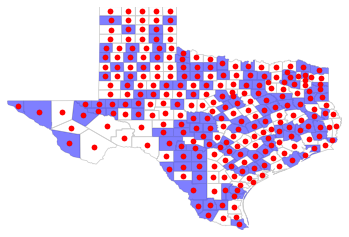

In [2]:
shp_link = '../data/texas.shp'
shp = ps.open(shp_link)
some = [bool(rdm.getrandbits(1)) for i in ps.open(shp_link)]

fig = figure()

base = maps.map_poly_shp(shp)
base.set_facecolor('none')
base.set_linewidth(0.75)
base.set_edgecolor('0.8')
some = maps.map_poly_shp(shp, which=some)
some.set_alpha(0.5)
some.set_linewidth(0.)
cents = np.array([poly.centroid for poly in ps.open(shp_link)])
pts = scatter(cents[:, 0], cents[:, 1])
pts.set_color('red')

ax = maps.setup_ax([base, some, pts], [shp.bbox, shp.bbox, shp.bbox])
fig.add_axes(ax)
show()

### Medium-level component

This layer comprises functions that perform usual transformations on matplotlib objects, such as color coding objects (points, polygons, etc.) according to a series of values. This includes the following methods:

- base_choropleth_classless
- base_choropleth_unique

#### Example

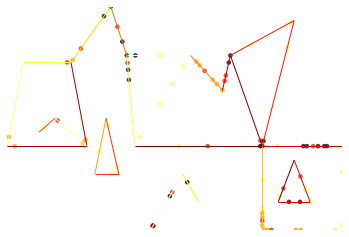

In [3]:
net_link = ps.examples.get_path('eberly_net.shp')
net = ps.open(net_link)
values = np.array(ps.open(net_link.replace('.shp', '.dbf')).by_col('TNODE'))

pts_link = ps.examples.get_path('eberly_net_pts_onnetwork.shp')
pts = ps.open(pts_link)

fig = figure()

netm = maps.map_line_shp(net)
netc = maps.base_choropleth_unique(netm, values)

ptsm = maps.map_point_shp(pts)
ptsm = maps.base_choropleth_classif(ptsm, values)
ptsm.set_alpha(0.5)
ptsm.set_linewidth(0.)

ax = maps.setup_ax([netc, ptsm], [net.bbox, net.bbox])
fig.add_axes(ax)
show()


callng plt.show()


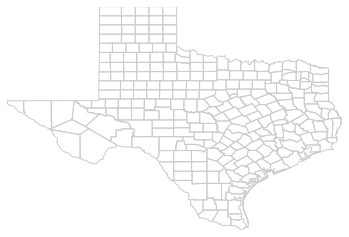

In [4]:
maps.plot_poly_lines('../data/texas.shp')


### Higher-level component

This currently includes the following end-user functions:

- plot_poly_lines: very quick shapfile plotting

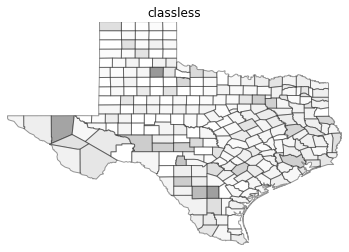

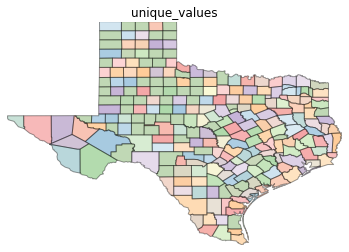

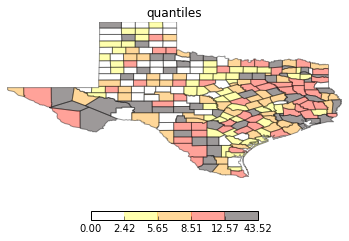

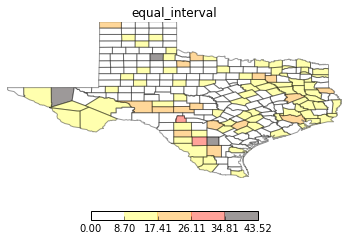

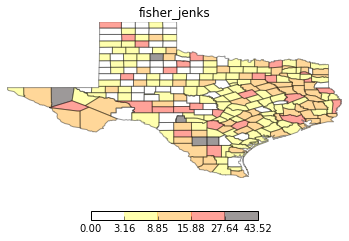

In [5]:
shp_link = '../data/texas.shp'
values = np.array(ps.open('../data/texas.dbf').by_col('HR90'))

types = ['classless', 'unique_values', 'quantiles', 'equal_interval', 'fisher_jenks']
for typ in types:
    maps.plot_choropleth(shp_link, values, typ, title=typ)

## GeoPandas

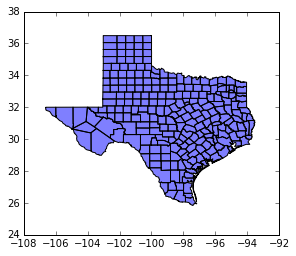

In [6]:
import geopandas as gpd
shp_link = "../data/texas.shp"
tx = gpd.read_file(shp_link)
tx.plot(color='blue')

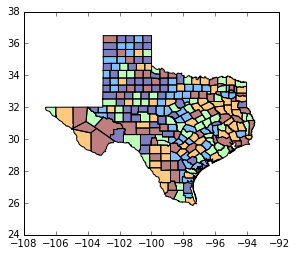

In [7]:
tx.plot(column='HR90', scheme='QUANTILES')

/home/serge/anaconda2/envs/pydata/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


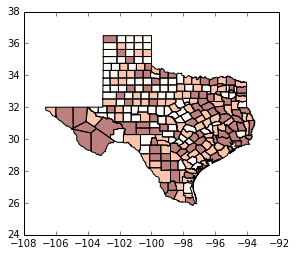

In [24]:
tx.plot(column='HR90', scheme='QUANTILES', k=3, colormap='OrRd')

/home/serge/anaconda2/envs/pydata/lib/python2.7/site-packages/geopandas/geodataframe.py:447: UserWarning: Invalid k: 10 (2 <= k <= 9), setting k=5 (default)
  return plot_dataframe(self, *args, **kwargs)


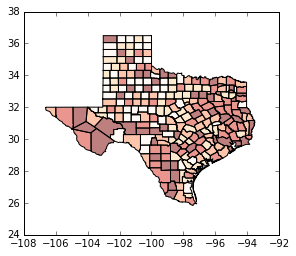

In [25]:
tx.plot(column='HR90', scheme='QUANTILES', k=10, colormap='OrRd')

## Folium

**Contributors:**

- Levi Wolf <levi.john.wolf@gmail.com>
- Serge Rey <sjsrey@gmail.com>

In addition to using matplotlib, the viz module includes components that interface with the [folium](http://folium.readthedocs.io/en/latest/) library which provides a Pythonic way to generate [Leaflet](http://leafletjs.com/) maps.


In [8]:
import pysal as ps
import geojson as gj
from pysal.contrib.viz import folium_mapping as fm


First, we need to convert the data into a JSON format. JSON, short for "Javascript Serialized Object Notation," is a simple and effective way to represent objects in a digital environment. For geographic information, the [GeoJSON](https://geojson.org) standard defines how to represent geographic information in JSON format. Python programmers may be more comfortable thinking of JSON data as something akin to a standard Python dictionary. 

In [9]:
filepath = '../data/texas.shp'[:-4]
shp = ps.open(filepath + '.shp')
dbf = ps.open(filepath + '.dbf')

In [10]:
js = fm.build_features(shp, dbf)

Just to show, this constructs a dictionary with the following keys:

In [11]:
js.keys()

[u'type', 'bbox', 'features']

In [12]:
js.type

'FeatureCollection'

In [13]:
js.bbox

[-106.6495132446289, 25.845197677612305, -93.50721740722656, 36.49387741088867]

In [14]:
js.features[0]

{"bbox": [-100.5494155883789, 36.05754852294922, -99.99715423583984, 36.49387741088867], "geometry": {"coordinates": [[[-100.00686645507812, 36.49387741088867], [-100.00114440917969, 36.49251937866211], [-99.99715423583984, 36.05754852294922], [-100.54059600830078, 36.058135986328125], [-100.5494155883789, 36.48944854736328], [-100.00686645507812, 36.49387741088867]]], "type": "Polygon"}, "properties": {"BLK60": 0.029359953, "BLK70": 0.0286861733, "BLK80": 0.0265533723, "BLK90": 0.0318167356, "CNTY_FIPS": "295", "COFIPS": 295, "DNL60": 1.293817423, "DNL70": 1.3170337879, "DNL80": 1.3953635084, "DNL90": 1.2153856529, "DV60": 1.4948859166, "DV70": 2.2709475333, "DV80": 3.5164835165, "DV90": 6.1016949153, "FH60": 6.7245119306, "FH70": 4.5, "FH80": 3.8353601497, "FH90": 6.0935799782, "FIPS": "48295", "FIPSNO": 48295, "FP59": 22.4, "FP69": 12.1, "FP79": 10.851262862, "FP89": 9.1403699674, "GI59": 0.2869290401, "GI69": 0.378218563, "GI79": 0.4070049836, "GI89": 0.3730049522, "HC60": 0.0, "HC

Then, we write the json to a file:

In [15]:
with open('./example.json', 'w') as out:
    gj.dump(js, out)

### Mapping
Let's look at the columns that we are going to map.

In [16]:
list(js.features[0].properties.keys())[:5]

[u'HR90', u'PS90', u'FH80', u'HC60', u'FP79']

We can map these attributes by calling them as arguments to the choropleth mapping function:

In [17]:
import folium as fol

In [18]:
fm.choropleth_map?

In [19]:
fm.choropleth_map('./example.json', 'FIPS', 'HR90',zoom_start=6)

/home/serge/anaconda2/envs/pydata/lib/python2.7/site-packages/folium/folium.py:504: UserWarning: This method is deprecated. Please use Map.choropleth instead.
  warnings.warn('This method is deprecated. '


This produces a map using default classifications and color schemes and saves it to an html file. We set the function to have sane defaults. However, if the user wants to have more control, we have many options available. 

There are arguments to change the classification scheme:

In [20]:
fm.choropleth_map('./example.json', 'FIPS', 'HR90', classification = 'Quantiles')

Most PySAL classifiers are supported.

### Base Map Type



In [21]:
fm.choropleth_map('./example.json', 'FIPS', 'HR90', classification = 'Jenks Caspall', tiles='Stamen Toner',zoom_start=6, save=True) 

We support the entire range of builtin basemap types in Folium, but custom tilesets from MapBox are not supported (yet).
 
### Color Scheme

In [22]:
fm.choropleth_map('./example.json', 'FIPS', 'HR80', classification = 'Jenks Caspall', tiles='Stamen Toner', fill_color = 'PuBuGn', save=True) 

All color schemes are [Color Brewer](https://colorbrewer2.org) and simply pass through to `Folium` on execution. 

### Class numbers

In [23]:
fm.choropleth_map('./example.json', 'FIPS', 'HR80', classification = 'Equal Interval', classes=6, tiles='Stamen Toner', fill_color='PuBuGn',save=True) 

Folium supports up to 6 classes.

## Cartopy

Althought we don't have time to go into the details here today, we note that for for publication ready maps one can turn to [Cartopy](https://github.com/SciTools/cartopy). For an example of a recent publication and code see [Rey (2016)](https://github.com/sjsrey/limaaag).

In [38]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

reader = shpreader.Reader("../data/texas.shp")


In [55]:
def choropleth(classes, colors, reader, legend=None, title=None, fileName=None, dpi=600):
    ax = plt.axes([0,0,1,1], projection=ccrs.LambertConformal())
    ax.set_extent([-108, -93, 38, 24], ccrs.Geodetic())
    ax.background_patch.set_visible(False)
    ax.outline_patch.set_visible(False)
    if title:
        plt.title(title)
    ax.set_extent([-108, -93, 38, 24], ccrs.Geodetic())
    ax.background_patch.set_visible(False)
    ax.outline_patch.set_visible(False)
    
    for i,state in enumerate(reader.geometries()):
        facecolor = colors[classes[i]]
        #facecolor = 'red'
        edgecolor = 'black'
        ax.add_geometries([state], ccrs.PlateCarree(), 
                         facecolor=facecolor, edgecolor=edgecolor)
        
    leg = [ mpatches.Rectangle((0,0),1,1, facecolor=color) for color in colors]
    if legend:
        plt.legend(leg, legend, loc='lower left', bbox_to_anchor=(0.025, -0.1), fancybox=True)
    if fileName:
        plt.savefig(fileName, dpi=dpi)
    plt.show()

In [56]:
HR90 = values

In [57]:
bins_q5 = ps.Quantiles(HR90, k=5)

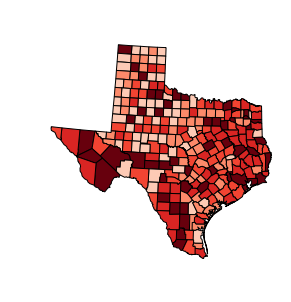

In [58]:
bwr = plt.cm.get_cmap('Reds')
bwr(.76)
c5 = [bwr(c) for c in [0.2, 0.4, 0.6, 0.7, 1.0]]
classes = bins_q5.yb
choropleth(classes, c5, reader)


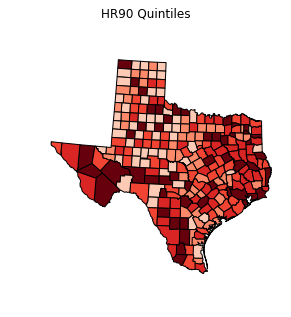

In [62]:
choropleth(classes, c5, reader, title="HR90 Quintiles")


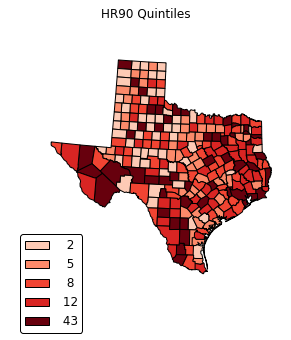

In [65]:
legend =[ "%3d"%ub for ub in bins_q5.bins]
choropleth(classes, c5, reader, legend, title="HR90 Quintiles")
